<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Is-any-question/class-a-nan-?" data-toc-modified-id="Is-any-question/class-a-nan-?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Is any question/class a nan ?</a></span></li><li><span><a href="#What-is-the-distribution-of-classes-?" data-toc-modified-id="What-is-the-distribution-of-classes-?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>What is the distribution of classes ?</a></span></li></ul></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Used to import libraries from an absolute path starting with the project's root
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# EDA

In [3]:
dataset = pd.read_csv("../data/dataset.csv")
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
dataset.shape

(404290, 6)

In [13]:
dataset.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

## Is any question/class a nan ?

In [7]:
dataset[dataset["question1"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
dataset[dataset["question2"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [12]:
dataset[dataset["is_duplicate"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate


## What is the distribution of classes ?

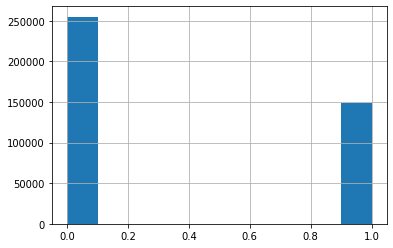

In [16]:
dataset["is_duplicate"].hist()

We notice a slight imbalance of the dataset with around 150k positive similar sequences and 250k dissimilar sequences.

# Data Cleaning

We remove the found nan values.

In [14]:
new_dataset = dataset[dataset["question1"].isnull() == False]
new_dataset = new_dataset[new_dataset["question2"].isnull() == False]

In [1]:
new_dataset.to_csv("../data/cleaned_dataset.csv")

NameError: name 'new_dataset' is not defined

We remove the questions triggering errors in our Word2Vec modelby first fitting our model to our dataset then iterating over our dataset to transform it, removing buggy values at ther same time.

In [3]:
new_dataset = pd.read_csv("../data/cleaned_dataset.csv")
questions = np.concatenate(
    (new_dataset["question1"].to_numpy(), new_dataset["question2"].to_numpy())
)

In [4]:
from src.preprocessing.word2Vec import Word2VecModel

word2Vec = Word2VecModel(vector_size = 40, detect_bigrams = False, debug=False)
word2Vec.fit(questions)

In [5]:
from tqdm import tqdm

tqdm.pandas()

In [6]:
def transform_dataset(row):
    question1 = row["question1"]
    question2 = row["question2"]

    question1 = word2Vec.transform(question1)
    question2 = word2Vec.transform(question2)
    
    #if the returned vector of word embedding is empty, the sentence is good to be thrown
    if (len(question1) == 0 or len(question2) == 0):
        print(True)
        failed_row = True
    else:
        failed_row = False
        
    return pd.Series([question1, question2, failed_row])
    
new_dataset[["question1", "question2", "failed_row"]] = new_dataset.progress_apply(
    transform_dataset, axis=1
)

  1%|▌                                                                          | 3343/404287 [00:30<50:58, 131.09it/s]

True


  3%|██▍                                                                       | 13049/404287 [01:48<47:44, 136.57it/s]

True


  3%|██▌                                                                       | 13831/404287 [01:54<52:46, 123.31it/s]

True


  5%|███▋                                                                      | 20109/404287 [02:45<56:27, 113.41it/s]

True


  5%|███▊                                                                      | 20835/404287 [02:51<54:40, 116.87it/s]

True


  9%|██████▎                                                                   | 34794/404287 [04:45<54:46, 112.43it/s]

True


 12%|████████▌                                                                 | 47083/404287 [06:36<47:31, 125.27it/s]

True


 22%|████████████████▌                                                         | 90519/404287 [12:51<44:19, 117.97it/s]

True


 24%|█████████████████▋                                                        | 96767/404287 [13:46<42:54, 119.46it/s]

True


 26%|██████████████████▊                                                      | 104133/404287 [14:51<41:13, 121.36it/s]

True


 27%|███████████████████▋                                                     | 109014/404287 [15:35<43:36, 112.84it/s]

True


 29%|████████████████████▊                                                    | 115366/404287 [16:30<42:07, 114.29it/s]

True


 33%|████████████████████████▎                                                | 134429/404287 [19:18<39:15, 114.56it/s]

True


 36%|██████████████████████████                                               | 144377/404287 [20:49<38:39, 112.08it/s]

True


 38%|███████████████████████████▍                                             | 151946/404287 [21:55<32:44, 128.47it/s]

True


 42%|██████████████████████████████▌                                          | 169320/404287 [24:22<30:50, 126.95it/s]

True


 45%|████████████████████████████████▉                                        | 182629/404287 [26:18<36:05, 102.35it/s]

True


 47%|██████████████████████████████████▎                                      | 189695/404287 [27:21<30:48, 116.11it/s]

True


 47%|██████████████████████████████████▍                                      | 190590/404287 [27:29<34:18, 103.83it/s]

True


 49%|███████████████████████████████████▉                                     | 198942/404287 [28:42<30:08, 113.54it/s]

True


 52%|█████████████████████████████████████▋                                   | 208502/404287 [30:06<29:47, 109.53it/s]

True


 53%|██████████████████████████████████████▌                                  | 213252/404287 [30:48<28:28, 111.82it/s]

True


 54%|███████████████████████████████████████▎                                 | 217497/404287 [31:25<27:22, 113.73it/s]

True


 55%|████████████████████████████████████████▏                                | 222744/404287 [32:11<26:26, 114.45it/s]

True


 56%|████████████████████████████████████████▉                                | 226966/404287 [32:49<24:10, 122.29it/s]

True


 61%|████████████████████████████████████████████▍                            | 245901/404287 [35:38<25:09, 104.94it/s]

True


 63%|██████████████████████████████████████████████▌                           | 254176/404287 [36:47<30:41, 81.54it/s]

True


 68%|█████████████████████████████████████████████████▎                       | 273109/404287 [39:25<16:30, 132.45it/s]

True


 72%|████████████████████████████████████████████████████▍                    | 290125/404287 [41:47<15:01, 126.65it/s]

True


 75%|██████████████████████████████████████████████████████▍                  | 301620/404287 [43:19<12:41, 134.80it/s]

True


 85%|█████████████████████████████████████████████████████████████▊           | 342177/404287 [49:02<08:31, 121.51it/s]

True


 95%|█████████████████████████████████████████████████████████████████████▍   | 384317/404287 [55:10<03:07, 106.45it/s]

True


100%|████████████████████████████████████████████████████████████████████████▋| 402450/404287 [58:03<00:16, 114.27it/s]

True


100%|█████████████████████████████████████████████████████████████████████████| 404287/404287 [58:45<00:00, 114.67it/s]


In [7]:
new_dataset.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,failed_row
0,0,0,1,2,"[[[0.048575282, 0.02121299, 0.01206447, 0.1411...","[[[0.048575282, 0.02121299, 0.01206447, 0.1411...",0,False
1,1,1,3,4,"[[[0.048575282, 0.02121299, 0.01206447, 0.1411...","[[[0.048575282, 0.02121299, 0.01206447, 0.1411...",0,False
2,2,2,5,6,"[[[-0.14803627, -0.0150878625, -0.14985664, 0....","[[[-0.14803627, -0.0150878625, -0.14985664, 0....",0,False
3,3,3,7,8,"[[[0.048575282, 0.02121299, 0.01206447, 0.1411...","[[[0.057202253, 0.021237576, 0.13157405, 0.073...",0,False
4,4,4,9,10,"[[[0.048575282, 0.02121299, 0.01206447, 0.1411...","[[[0.048575282, 0.02121299, 0.01206447, 0.1411...",0,False


In [ ]:
new_dataset[new_dataset["failed_row"] == False].to_pickle("D:/thoma/vectorized_dataset.pkl")